In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from numpy import pi as pi

/home/anna/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Ulstrasound data from free surface measurements
wavemaker amplitude = 0.1 [V]  
wavemaker frequezy = 2 [Hz]


In [2]:
data_dir = '/home/anna/annaCode/MEK4600/ultrasound_data'
run_file2 = 'f2_a01_r2.csv'
run_file3 = 'f2_a005_r3.csv'

def read_data_from_file(file_name):
    file_path = os.path.join(data_dir, file_name)
    columns = ['time_string', 'sensor1', 'sensor2' ,'sensor3', 'sensor4', 'sound_test']
    df = pd.read_csv(file_path, names=columns)
    df['time'] = df['time_string'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M:%S.%f'))
    return df
df = read_data_from_file(run_file2)
df3 = read_data_from_file(run_file3)

df.head(2)

,time_string,sensor1,sensor2,sensor3,sensor4,sound_test,time
0,09/12/2024 11:28:50.728,0.14928,0.14722,0.14808,0.14817,343.59,2024-09-12 11:28:50.728
1,09/12/2024 11:28:50.736,0.14937,0.14731,0.14817,0.14808,343.59,2024-09-12 11:28:50.736


# I am only interested in data from sensor 4 because it was placed directly the place where waves were investigated. 
# The code below is finding timestamps/indices for data points when wave elevation crosses still water level
still water level - the level at which the liquid was still, 

In [3]:
def get_crossing_points(df):
    sensor4 = df['sensor4'].to_numpy()
    free_surface_level = df.sensor4.mean()
    crossing_indices = np.where((sensor4[:-1] < free_surface_level) & (sensor4[1:] > free_surface_level) | 
                                (sensor4[:-1] > free_surface_level) & (sensor4[1:] < free_surface_level))[0]
    df['crossing' ]  = False
    df.loc[crossing_indices, 'crossing'] = True
    return free_surface_level

free_surface_level = get_crossing_points(df)
free_surface_level3 = get_crossing_points(df3)

# Checking if detection was correct on a slice of data

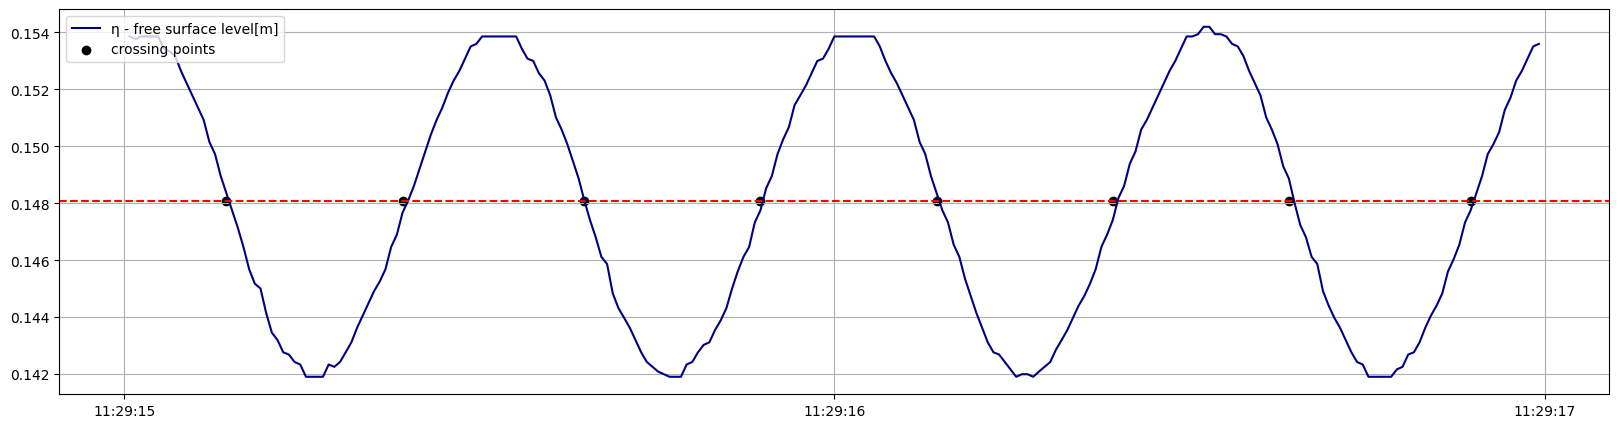

In [4]:
time_format = '%m/%d/%Y %H:%M:%S'
cut_off_string_1 = '09/12/2024 11:29:15'
cut_off_time_1 = datetime.strptime(cut_off_string_1,time_format )
cut_off_string_2 = '09/12/2024 11:29:17'
cut_off_time_2 = datetime.strptime(cut_off_string_2, time_format)
subset_df = df[(df['time'] > cut_off_time_1) & (df['time'] < cut_off_time_2)].copy()
croosing_points = subset_df[subset_df['crossing'] == True]

plt.figure(figsize=(20, 5)) 

plt.plot(subset_df['time'], subset_df['sensor4'], linestyle='-', color='navy', label = 'η - free surface level[m]' )
plt.scatter(croosing_points['time'],  [free_surface_level] * len(croosing_points), marker = 'o',  color='black', label='crossing points')

plt.grid(True) 
plt.legend(loc='upper left')
plt.axhline(y=free_surface_level, color='r', linestyle='--', label=f'y = free surface')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.SecondLocator(interval=1)) 
plt.show()

# finding amplitudes and stroing them  at indices corresponding to crests

In [5]:
def find_crossing_points(df, free_surface_level):
    start_idx = 0
    crests = []
    df['amplitude'] = None
    for idx, row in df.iterrows():
        if row['crossing'] == True:
            amplitude = df.loc[start_idx+1:idx-1, 'sensor4'].max()
            if amplitude > free_surface_level:
                crest_idx = start_idx + int((idx-1 - start_idx)/2)
                crests.append(crest_idx)
                df.loc[crest_idx, 'amplitude'] = amplitude - free_surface_level
            start_idx = idx

find_crossing_points(df, free_surface_level)
find_crossing_points(df3, free_surface_level3)

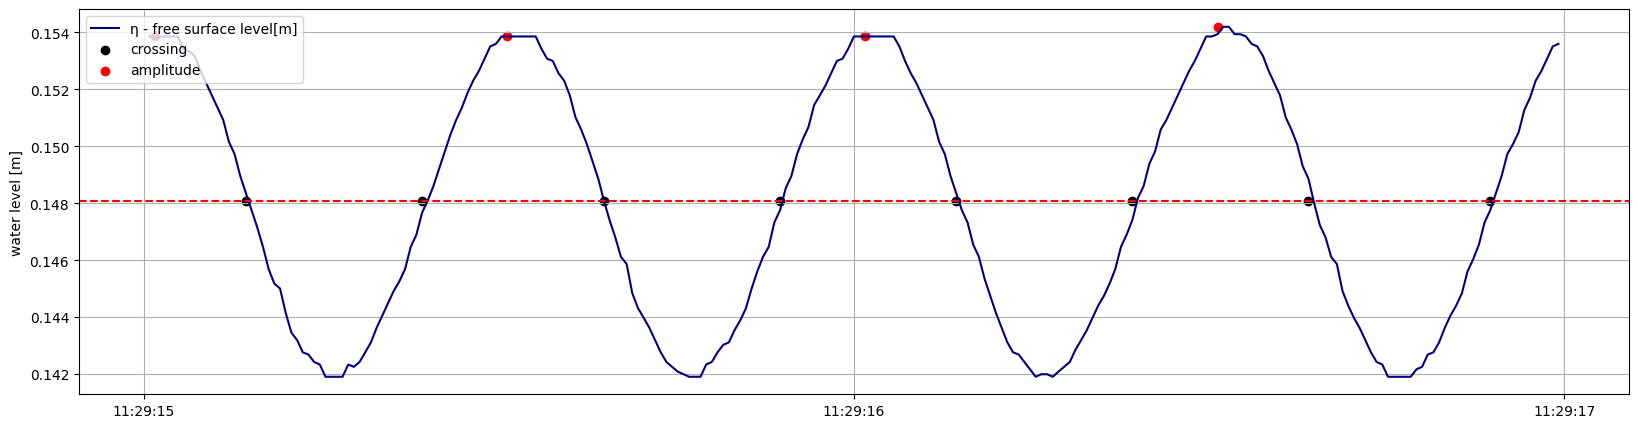

In [6]:
cut_off_string_1 = '09/12/2024 11:29:15'
cut_off_time_1 = datetime.strptime(cut_off_string_1, time_format)
cut_off_string_2 = '09/12/2024 11:29:17'
cut_off_time_2 = datetime.strptime(cut_off_string_2, time_format)
subset_df = df[(df['time'] > cut_off_time_1) & (df['time'] < cut_off_time_2)].copy()
crosing_points = subset_df[subset_df['crossing'] == True]
crest_points = subset_df[subset_df['amplitude'].notna()]
plt.figure(figsize=(20, 5))  # optional, to set the figure size
plt.plot(subset_df['time'], subset_df['sensor4'], linestyle='-', color='navy', label = 'η - free surface level[m]')
plt.scatter(croosing_points['time'],  [free_surface_level] * len(croosing_points), marker = 'o',  color='black', label='crossing')
plt.scatter(crest_points['time'],  crest_points['amplitude'] + free_surface_level, marker = 'o',  color='red', label='amplitude')
plt.grid(True) 
plt.legend(loc='upper left')
plt.ylabel('water level [m]')
plt.axhline(y=free_surface_level, color='r', linestyle='--', label=f'y = free surface')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.SecondLocator(interval=1)) 
plt.show()

In [7]:
crest_points.sensor4.max()-free_surface_level

0.005866572685462895

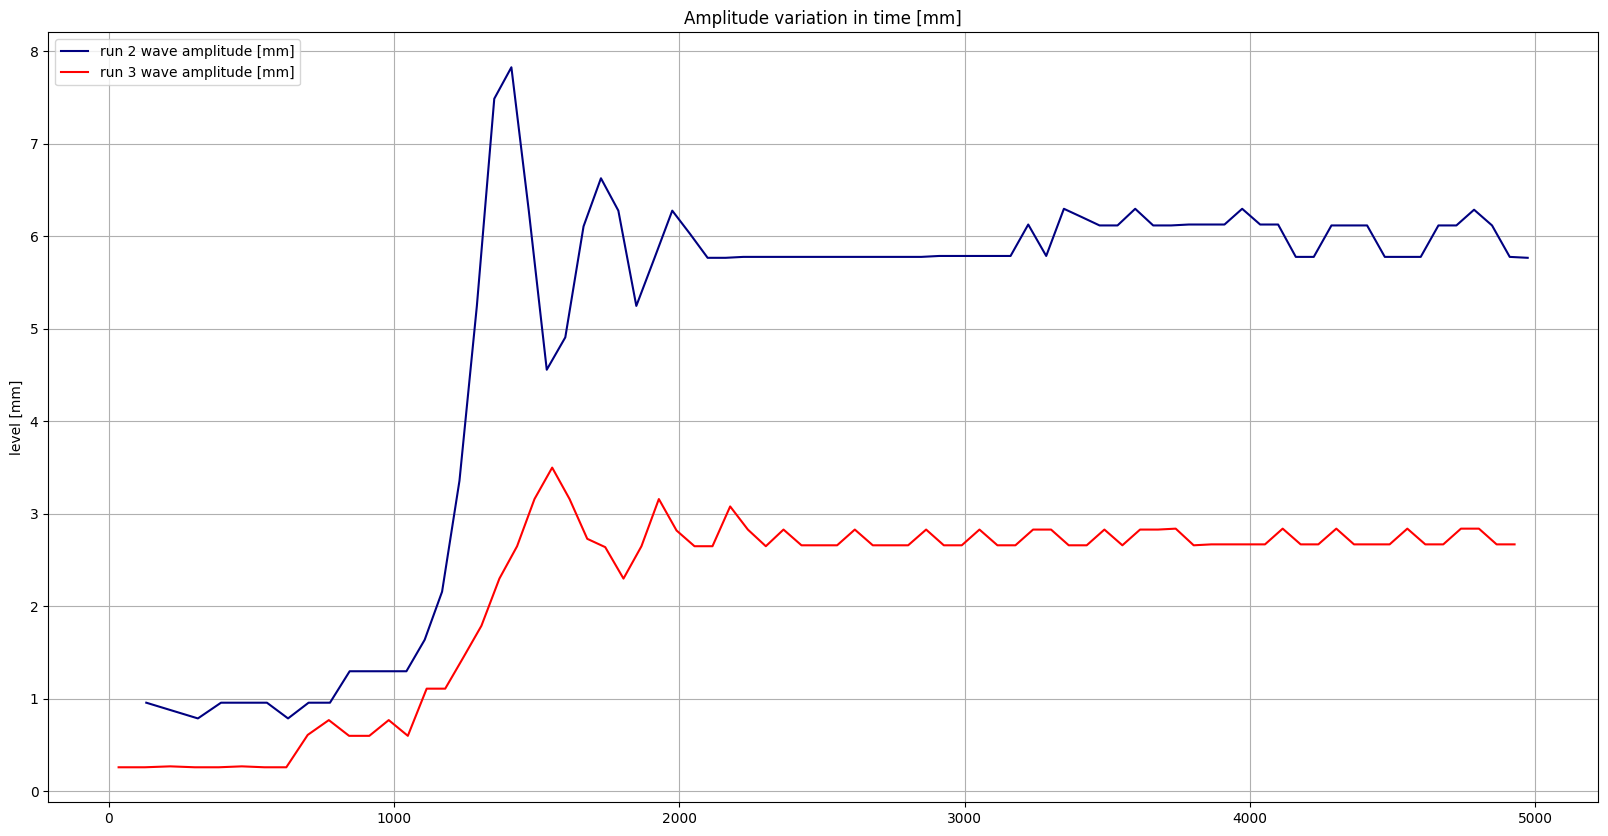

In [8]:
crest_points = df[df['amplitude'].notna()].copy()
crest_points3 = df3[df3['amplitude'].notna()].copy()

plt.figure(figsize=(20, 10)) 
plt.plot(crest_points.index, crest_points['amplitude'] * 1000, linestyle='-', color='navy', label = "run 2 wave amplitude [mm]")
plt.plot(crest_points3.index, crest_points3['amplitude'] * 1000, linestyle='-', color='red', label = "run 3 wave amplitude [mm]")

plt.legend(loc='upper left')
plt.grid(True) 
plt.ylabel('level [mm]')
_ = plt.title("Amplitude variation in time [mm]")
#_ = plt.xticks(rotation=45)

# Non-linear dispersion relation:
$$\omega^2=g k \tanh (k h)\left\{1+k^2 a^2\left[\frac{9}{8}\left(\alpha^2-1\right)^2+\alpha^2\right]\right\}$$  
where: $$\alpha=\operatorname{coth} (k h)$$  
### for deep water waves:  
$$\omega^2=g k (1+k^2 a^2)$$

In [9]:
def get_wave_number_from_disp_relation(a, omega):
    g = 9.81
    # Coefficients of the polynomial:
    coefficients = [g*a**2, 0, g, -omega**2]
    roots = np.roots(coefficients)
    positive = list(filter(lambda x: x.real > 0, roots))
    return positive[0].real

def get_wave_numbers_and_steepness(df):
    crest_points = df[df['amplitude'].notna()].copy()
    crest_points['k'] = 0
    crest_points['ak'] = 0
    f = 2 # [Hz]
    omega = 2 * np.pi * f
    crest_points['k'] = crest_points['amplitude'].apply(lambda x: get_wave_number_from_disp_relation(x, omega))
    crest_points['ak'] = crest_points['amplitude'] * crest_points['k']
    return crest_points

crests = get_wave_numbers_and_steepness(df)
crests3 = get_wave_numbers_and_steepness(df3)

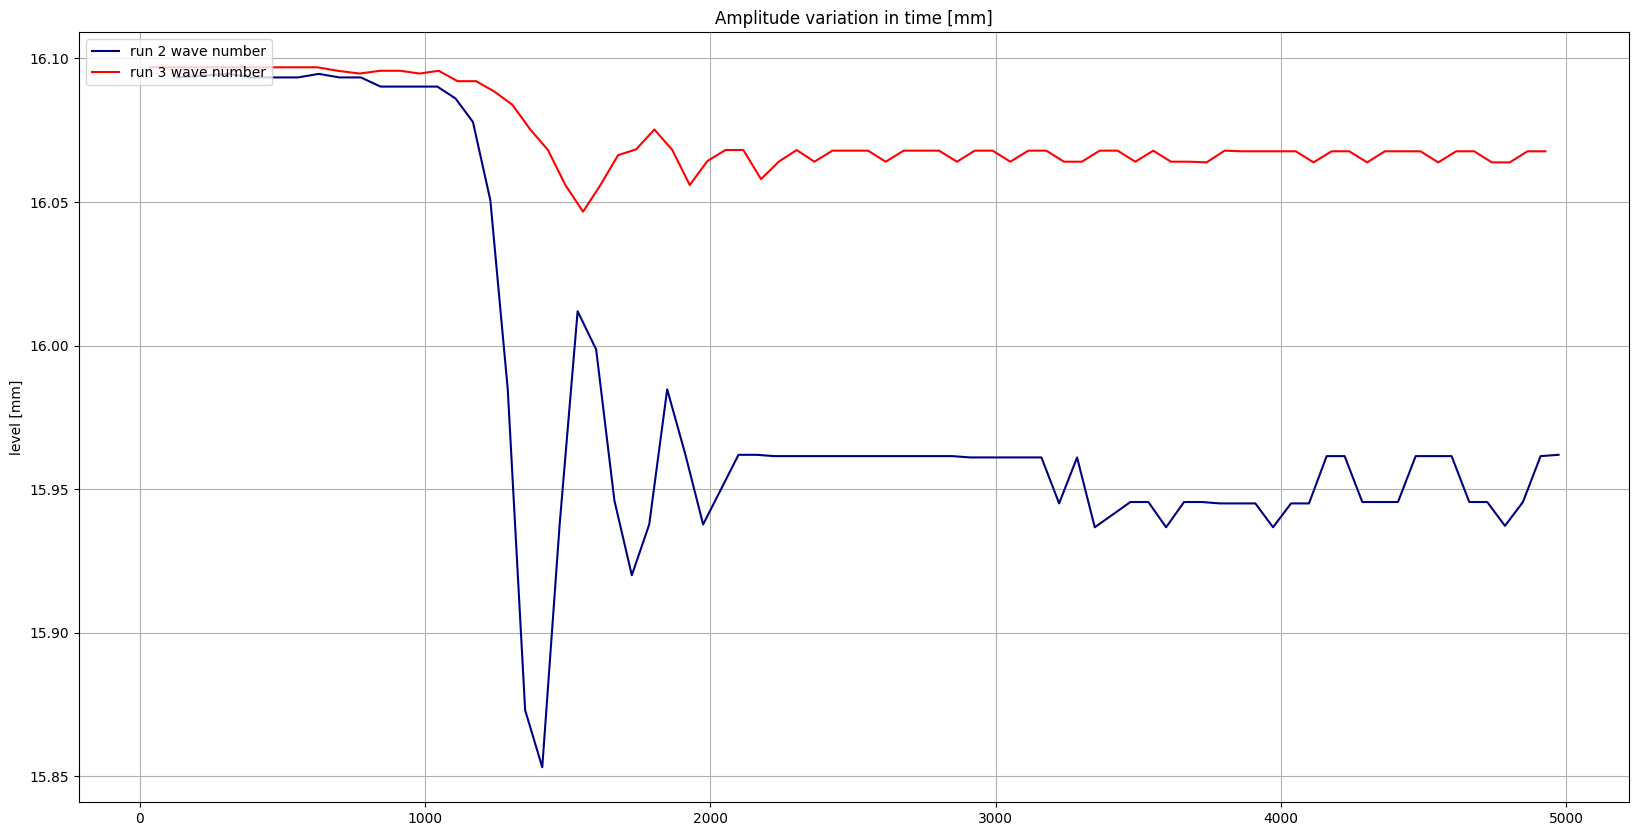

In [10]:
plt.figure(figsize=(20, 10)) 
plt.plot(crests.index, crests['k'] , linestyle='-', color='navy', label = "run 2 wave number")
plt.plot(crests3.index, crests3['k'], linestyle='-', color='red', label = "run 3 wave number")

plt.legend(loc='upper left')
plt.grid(True) 
plt.ylabel('level [mm]')
_ = plt.title("Amplitude variation in time [mm]")
#_ = plt.xticks(rotation=45)

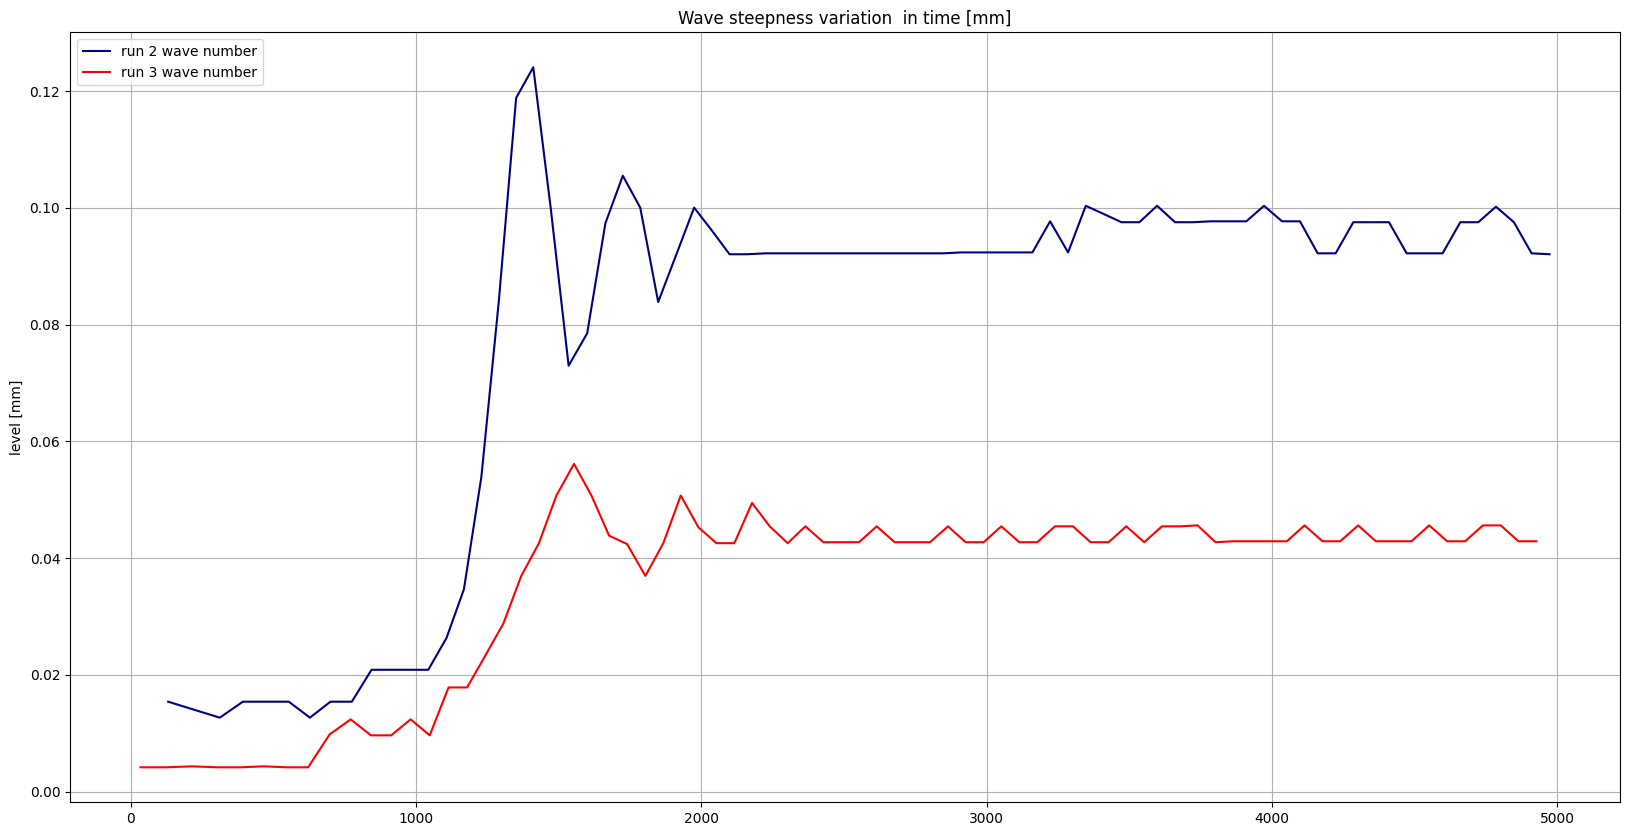

In [11]:
plt.figure(figsize=(20, 10)) 
plt.plot(crests.index, crests['ak'] , linestyle='-', color='navy', label = "run 2 wave number")
plt.plot(crests3.index, crests3['ak'], linestyle='-', color='red', label = "run 3 wave number")

plt.legend(loc='upper left')
plt.grid(True) 
plt.ylabel('level [mm]')
_ = plt.title("Wave steepness variation  in time [mm]")
#_ = plt.xticks(rotation=45)